In [12]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch
from torch.utils.data import DataLoader
import os

import torch.nn as nn
import torch.nn.functional as F
from collections import Counter

import os
from PIL import Image

import torch.optim as optim
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [20]:
# Plotting function with labels on bars
def plot_distribution(counts, title, dataset_name):
    classes = list(counts.keys())
    frequencies = list(counts.values())
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(classes, frequencies, color='skyblue')
    plt.xlabel('Class Labels')
    plt.ylabel('Number of Samples')
    plt.title(f"{title} Distribution")
    plt.xticks(classes)  # Set class labels on x-axis
    
    # Adding text labels on top of the bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

    plt.show()

In [21]:
train_path =r'C:\Users\bebed\OneDrive\Desktop\DNN\da\dataset\imagenette2-160\train'
test_path = r'C:\Users\bebed\OneDrive\Desktop\DNN\da\dataset\imagenette2-160\val'

image_size = (160, 160) 


# Data Augmentation Transforms
# Data Augmentation Transforms
train_transform_augmented = transforms.Compose([
    transforms.Resize(image_size),  # Resize to common size
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(degrees=30),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_transform_basic = transforms.Compose([
    transforms.Resize(image_size),  # Resize to common size
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_transform = transforms.Compose([
    transforms.Resize(image_size),  # Resize to common size
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset_augmented = datasets.ImageFolder(root=train_path, transform=train_transform_augmented)
train_dataset_basic = datasets.ImageFolder(root=train_path, transform=train_transform_basic)
test_dataset = datasets.ImageFolder(root=test_path, transform=test_transform)

train_loader_augmented = DataLoader(train_dataset_augmented, batch_size=64, shuffle=True)
train_loader_basic = DataLoader(train_dataset_basic, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(len(train_dataset_augmented))
print(len(train_dataset_basic))
print(len(test_dataset))

9469
9469
3925


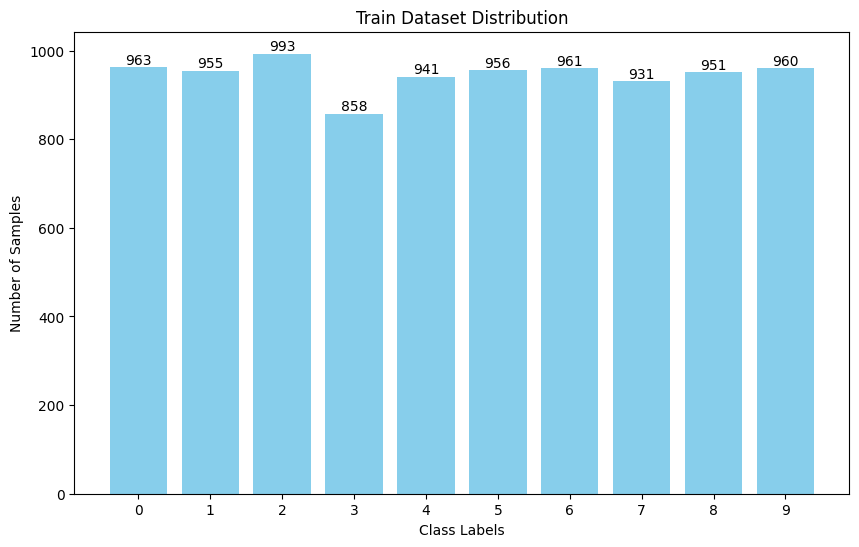

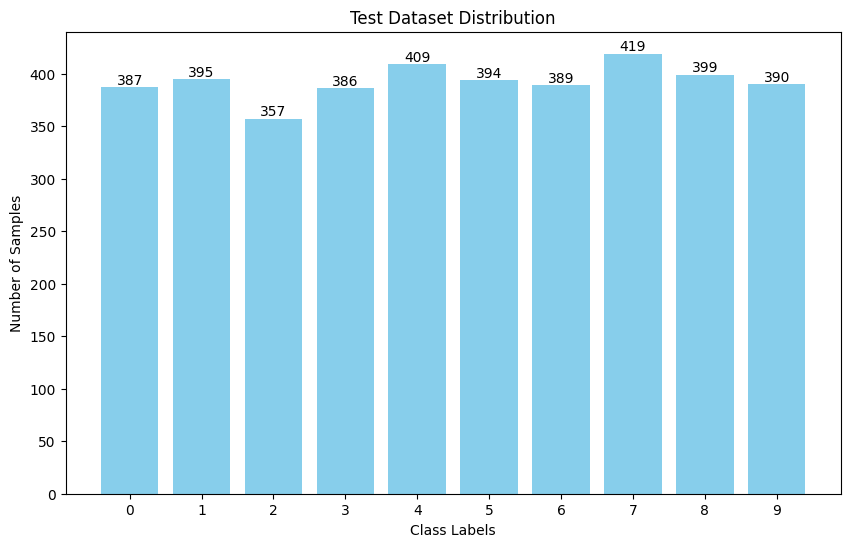

In [22]:
# Get the classes and the counts for each dataset
train_classes_basic = [label for _, label in train_dataset_basic]
test_classes = [label for _, label in test_dataset]

# Count the occurrences of each class
train_counts_basic = Counter(train_classes_basic)
test_counts = Counter(test_classes)

# Plot distributions for train and test datasets
plot_distribution(train_counts_basic, "Train Dataset", "Train")
plot_distribution(test_counts, "Test Dataset", "Test")

In [4]:
class SimpleCNN(nn.Module):
    def __init__(self, use_bn=False, dropout_rate=0.5):
        super(SimpleCNN, self).__init__()
        self.use_bn = use_bn
        self.use_dropout = dropout_rate > 0
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        
        self.fc1 = nn.Linear(256, 256)
        self.fc2 = nn.Linear(256, 10)  # 10 classes
        
        self.relu = nn.ReLU()
        self.global_pool = nn.AdaptiveAvgPool2d(1)

        if use_bn:
            self.bn1 = nn.BatchNorm2d(64)
            self.bn2 = nn.BatchNorm2d(128)
            self.bn3 = nn.BatchNorm2d(256)

        if self.use_dropout:
            self.dropout = nn.Dropout(dropout_rate)

        
    def forward(self, x):
        x = self.conv1(x)
        if self.use_bn: x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        if self.use_bn: x = self.bn2(x)
        x = self.relu(x)

        x = self.conv3(x)
        if self.use_bn: x = self.bn3(x)
        x = self.relu(x)

        x = self.global_pool(x)
        x = torch.flatten(x, 1)

        x = F.relu(self.fc1(x))
        if self.use_dropout: x = self.dropout(x)
        x = self.fc2(x)

        return x

In [10]:
model = SimpleCNN(use_bn=False, dropout_rate=0).to(device)
model

SimpleCNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (fc1): Linear(in_features=256, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
  (relu): ReLU()
  (global_pool): AdaptiveAvgPool2d(output_size=1)
)

In [33]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / len(train_loader.dataset)
    return epoch_loss, epoch_acc


In [34]:
def evaluate(model, test_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    correct = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(test_loader)
    epoch_acc = correct/ len(test_loader.dataset)
    return epoch_loss, epoch_acc

In [35]:
def plot_confusion_matrix(model, loader, device):
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [36]:
def plot_losses(train_losses, test_losses, train_accuracies, test_accuracies, config):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.title(f'Experiment {config} - Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(test_accuracies, label='Test Accuracy')
    plt.title(f'Experiment {config} - Accuracy Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [37]:
def run_config(config):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    criterion = nn.CrossEntropyLoss()

    # Select the appropriate data loader based on the first configuration
    train_loader = train_loader_augmented if config["data_augmentation"] else train_loader_basic

    # Initialize the model with the specified configurations
    model = SimpleCNN(use_bn=config["use_batchnorm"], dropout_rate=config["dropout_rate"])
    model.to(device)

    # Set up the optimizer
    weight_decay = 1e-4
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=weight_decay)

    # Initialize lists for tracking losses and accuracies
    train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []

    # Training loop for a specified number of epochs
    for epoch in range(20):
        train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
        test_loss, test_acc = evaluate(model, test_loader, criterion, device)

        # Append the results to the respective lists
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        # Print the results for the current epoch
        print(f"Epoch {epoch+1}/20 => Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")
    
    # Plot the confusion matrix
    plot_confusion_matrix(model, test_loader, device)
    plot_losses(train_losses, test_losses, train_accuracies, test_accuracies, config)


    return train_losses, test_losses, train_accuracies, test_accuracies

In [28]:
configs = [
    {"use_batchnorm": False, "dropout_rate": 0.0, "data_augmentation": False}, # 000
    {"use_batchnorm": True, "dropout_rate": 0.0, "data_augmentation": False},  # 100
    {"use_batchnorm": False, "dropout_rate": 0.5, "data_augmentation": False}, # 010
    {"use_batchnorm": False, "dropout_rate": 0.0, "data_augmentation": True},  # 001
    {"use_batchnorm": True, "dropout_rate": 0.5, "data_augmentation": True}    # 111
]


In [38]:
results = {}

# Base model

Epoch 1/20 => Train Loss: 2.1007, Train Acc: 0.2383, Test Loss: 1.9825, Test Acc: 0.2876
Epoch 2/20 => Train Loss: 1.9048, Train Acc: 0.3262, Test Loss: 1.8419, Test Acc: 0.3455
Epoch 3/20 => Train Loss: 1.7876, Train Acc: 0.3688, Test Loss: 1.7739, Test Acc: 0.3801
Epoch 4/20 => Train Loss: 1.6738, Train Acc: 0.4212, Test Loss: 1.6631, Test Acc: 0.4247
Epoch 5/20 => Train Loss: 1.5879, Train Acc: 0.4505, Test Loss: 1.5966, Test Acc: 0.4611
Epoch 6/20 => Train Loss: 1.5266, Train Acc: 0.4763, Test Loss: 1.5302, Test Acc: 0.4803
Epoch 7/20 => Train Loss: 1.4563, Train Acc: 0.5042, Test Loss: 1.5130, Test Acc: 0.4902
Epoch 8/20 => Train Loss: 1.3763, Train Acc: 0.5370, Test Loss: 1.3622, Test Acc: 0.5516
Epoch 9/20 => Train Loss: 1.3075, Train Acc: 0.5598, Test Loss: 1.3174, Test Acc: 0.5727
Epoch 10/20 => Train Loss: 1.2751, Train Acc: 0.5695, Test Loss: 1.2755, Test Acc: 0.5878
Epoch 11/20 => Train Loss: 1.2211, Train Acc: 0.5956, Test Loss: 1.2450, Test Acc: 0.5908
Epoch 12/20 => Trai

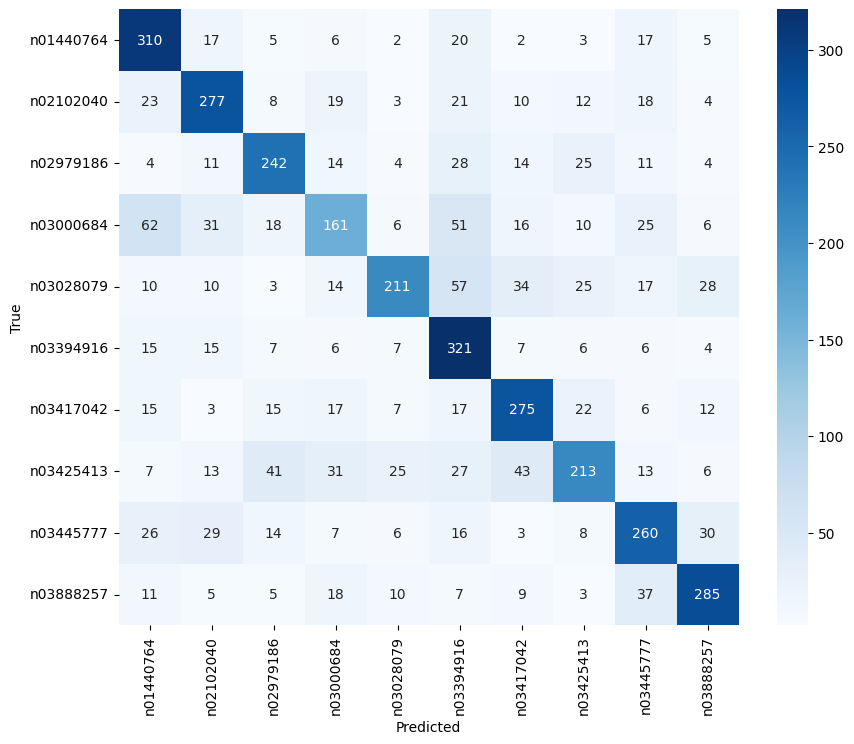

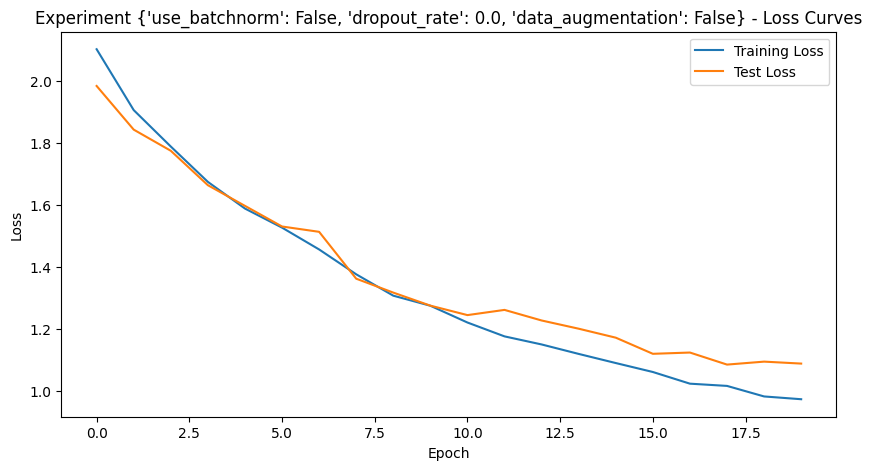

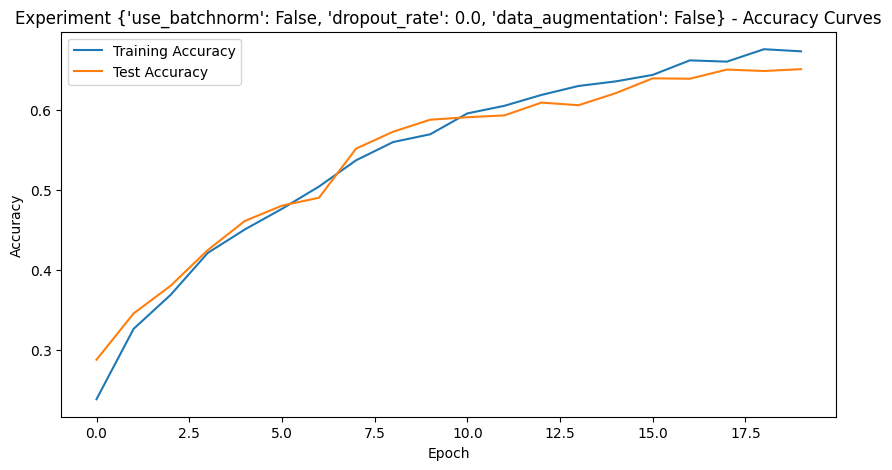

In [39]:
train_losses, test_losses, train_accuracies, test_accuracies = run_config(configs[0])


In [ ]:
results[0] = {
    "train_losses": train_losses,
    "test_losses": test_losses,
    "train_accuracies": train_accuracies,
    "test_accuracies": test_accuracies
}

# Base model with batch normalization

Epoch 1/20 => Train Loss: 1.7956, Train Acc: 0.3716, Test Loss: 1.6307, Test Acc: 0.4492
Epoch 2/20 => Train Loss: 1.4834, Train Acc: 0.5046, Test Loss: 1.5474, Test Acc: 0.4943
Epoch 3/20 => Train Loss: 1.3288, Train Acc: 0.5613, Test Loss: 1.4216, Test Acc: 0.4986
Epoch 4/20 => Train Loss: 1.2475, Train Acc: 0.5846, Test Loss: 1.4509, Test Acc: 0.5218
Epoch 5/20 => Train Loss: 1.1649, Train Acc: 0.6188, Test Loss: 1.2437, Test Acc: 0.5916
Epoch 6/20 => Train Loss: 1.0878, Train Acc: 0.6427, Test Loss: 1.1326, Test Acc: 0.6344
Epoch 7/20 => Train Loss: 1.0437, Train Acc: 0.6591, Test Loss: 1.1094, Test Acc: 0.6367
Epoch 8/20 => Train Loss: 1.0025, Train Acc: 0.6743, Test Loss: 1.1432, Test Acc: 0.6301
Epoch 9/20 => Train Loss: 0.9531, Train Acc: 0.6850, Test Loss: 1.1278, Test Acc: 0.6410
Epoch 10/20 => Train Loss: 0.9294, Train Acc: 0.6969, Test Loss: 1.1752, Test Acc: 0.6219
Epoch 11/20 => Train Loss: 0.8808, Train Acc: 0.7103, Test Loss: 1.3173, Test Acc: 0.6038
Epoch 12/20 => Trai

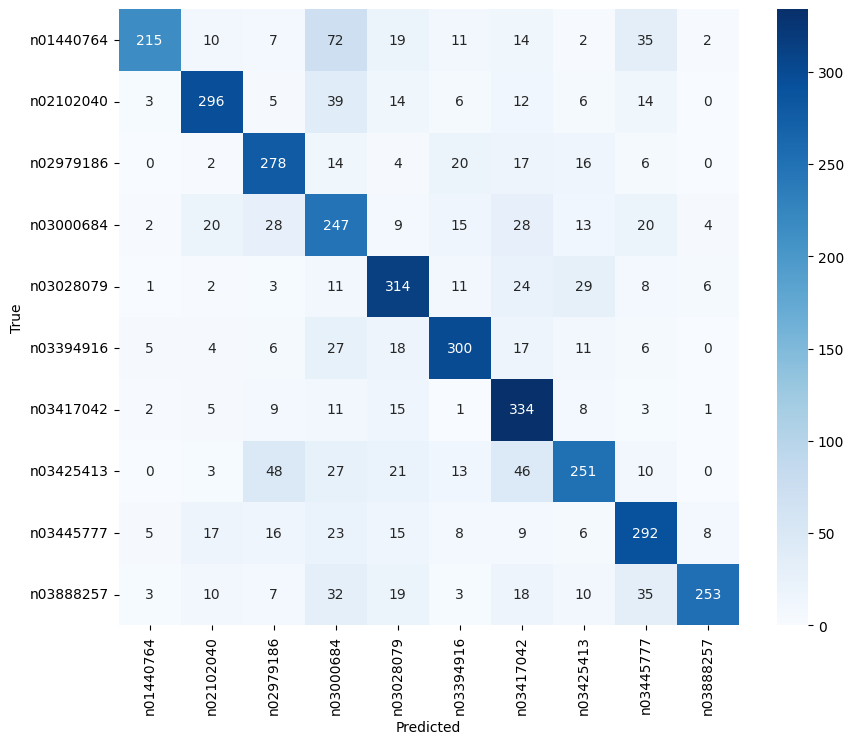

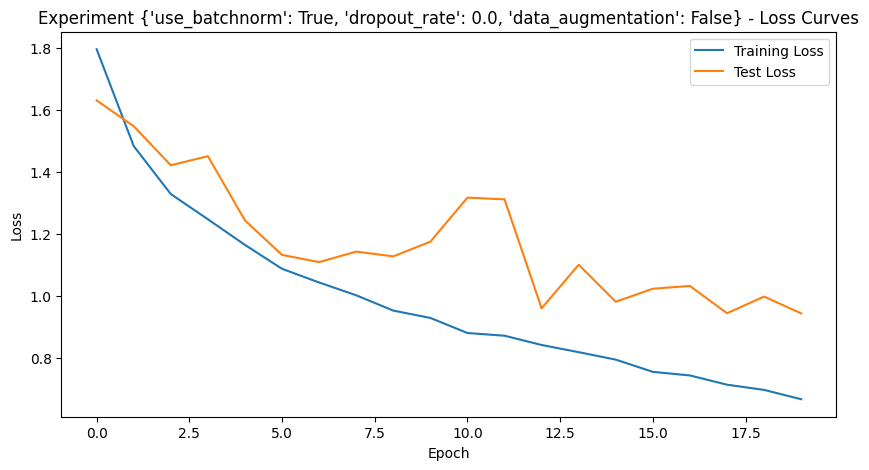

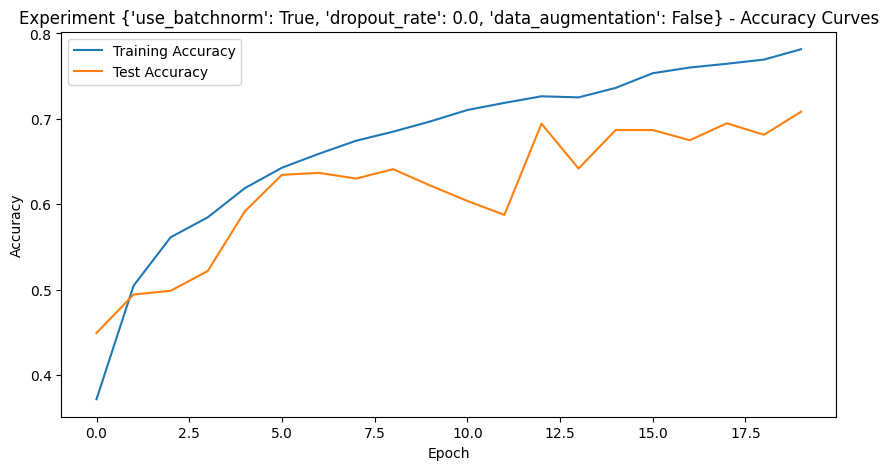

In [43]:
train_losses, test_losses, train_accuracies, test_accuracies = run_config(configs[1])
results[1] = {
    "train_losses": train_losses,
    "test_losses": test_losses,
    "train_accuracies": train_accuracies,
    "test_accuracies": test_accuracies
}

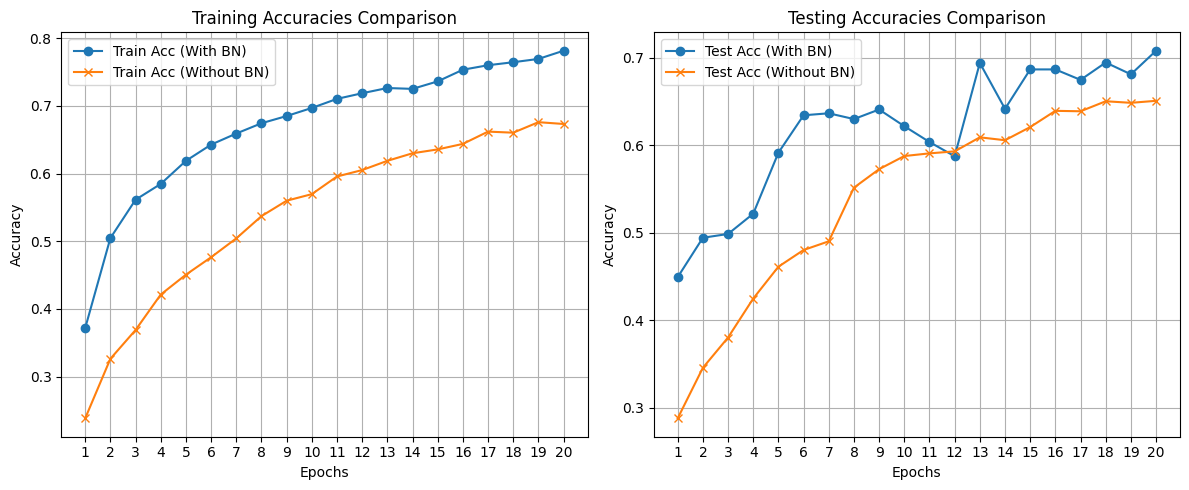

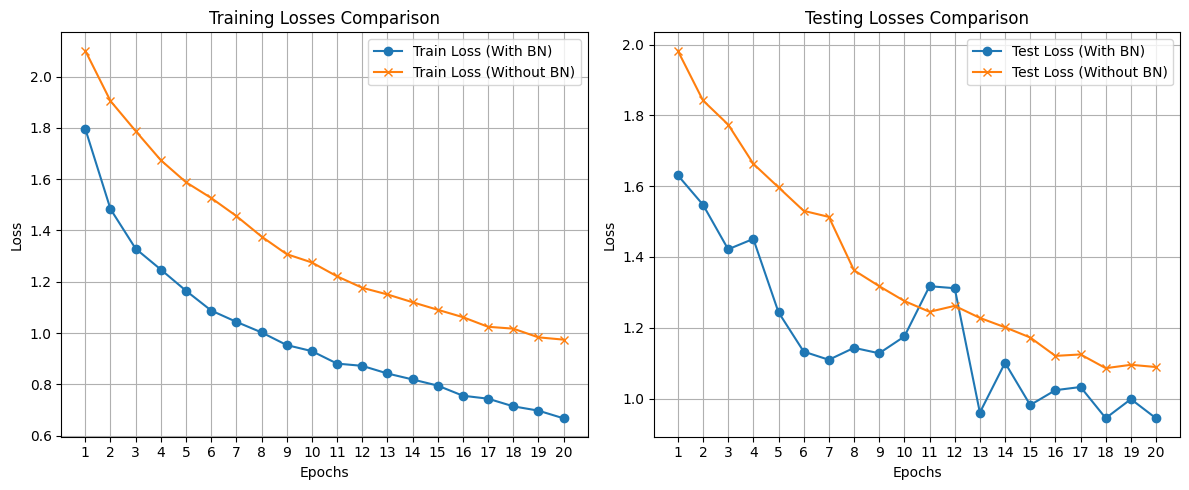

In [45]:

# Extract results for configurations with and without normalization
config_with_bn = results[1]  
config_without_bn = results[0]  

# Set up the epochs for x-axis
epochs = range(1, 21)  

# Plotting Train Accuracies
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)  # First subplot for accuracies
plt.plot(epochs, config_with_bn["train_accuracies"], label='Train Acc (With BN)', marker='o')
plt.plot(epochs, config_without_bn["train_accuracies"], label='Train Acc (Without BN)', marker='x')
plt.title('Training Accuracies Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(epochs)  # Set x-ticks to match epochs
plt.legend()
plt.grid()

# Plotting Test Accuracies
plt.subplot(1, 2, 2)  # Second subplot for test accuracies
plt.plot(epochs, config_with_bn["test_accuracies"], label='Test Acc (With BN)', marker='o')
plt.plot(epochs, config_without_bn["test_accuracies"], label='Test Acc (Without BN)', marker='x')
plt.title('Testing Accuracies Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(epochs)  # Set x-ticks to match epochs
plt.legend()
plt.grid()

# Show plots
plt.tight_layout()
plt.show()

# Plotting Train Losses
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)  # First subplot for losses
plt.plot(epochs, config_with_bn["train_losses"], label='Train Loss (With BN)', marker='o')
plt.plot(epochs, config_without_bn["train_losses"], label='Train Loss (Without BN)', marker='x')
plt.title('Training Losses Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs)  # Set x-ticks to match epochs
plt.legend()
plt.grid()

# Plotting Test Losses
plt.subplot(1, 2, 2)  # Second subplot for test losses
plt.plot(epochs, config_with_bn["test_losses"], label='Test Loss (With BN)', marker='o')
plt.plot(epochs, config_without_bn["test_losses"], label='Test Loss (Without BN)', marker='x')
plt.title('Testing Losses Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs)  # Set x-ticks to match epochs
plt.legend()
plt.grid()

# Show plots
plt.tight_layout()
plt.show()

# Base model with dropout

Epoch 1/20 => Train Loss: 2.1198, Train Acc: 0.2272, Test Loss: 1.9890, Test Acc: 0.2922
Epoch 2/20 => Train Loss: 1.9418, Train Acc: 0.3103, Test Loss: 1.8522, Test Acc: 0.3480
Epoch 3/20 => Train Loss: 1.8151, Train Acc: 0.3602, Test Loss: 1.7382, Test Acc: 0.3967
Epoch 4/20 => Train Loss: 1.7343, Train Acc: 0.3979, Test Loss: 1.6696, Test Acc: 0.4201
Epoch 5/20 => Train Loss: 1.6540, Train Acc: 0.4306, Test Loss: 1.5814, Test Acc: 0.4611
Epoch 6/20 => Train Loss: 1.5957, Train Acc: 0.4576, Test Loss: 1.5516, Test Acc: 0.4716
Epoch 7/20 => Train Loss: 1.5424, Train Acc: 0.4746, Test Loss: 1.4830, Test Acc: 0.5009
Epoch 8/20 => Train Loss: 1.4868, Train Acc: 0.4958, Test Loss: 1.4720, Test Acc: 0.5075
Epoch 9/20 => Train Loss: 1.4642, Train Acc: 0.5055, Test Loss: 1.4824, Test Acc: 0.5034
Epoch 10/20 => Train Loss: 1.4173, Train Acc: 0.5242, Test Loss: 1.4942, Test Acc: 0.5024
Epoch 11/20 => Train Loss: 1.3920, Train Acc: 0.5295, Test Loss: 1.3626, Test Acc: 0.5597
Epoch 12/20 => Trai

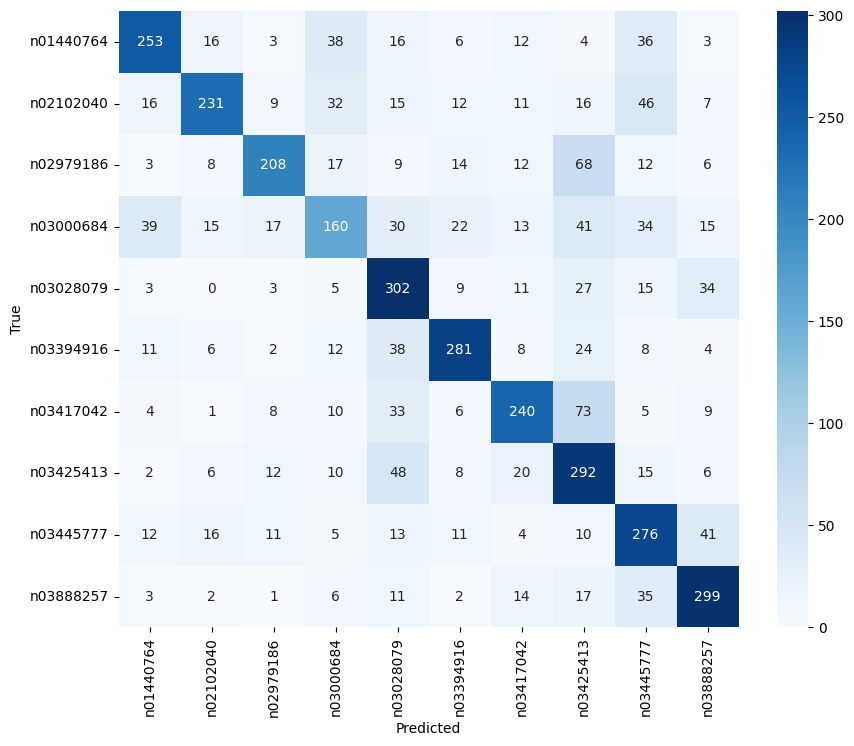

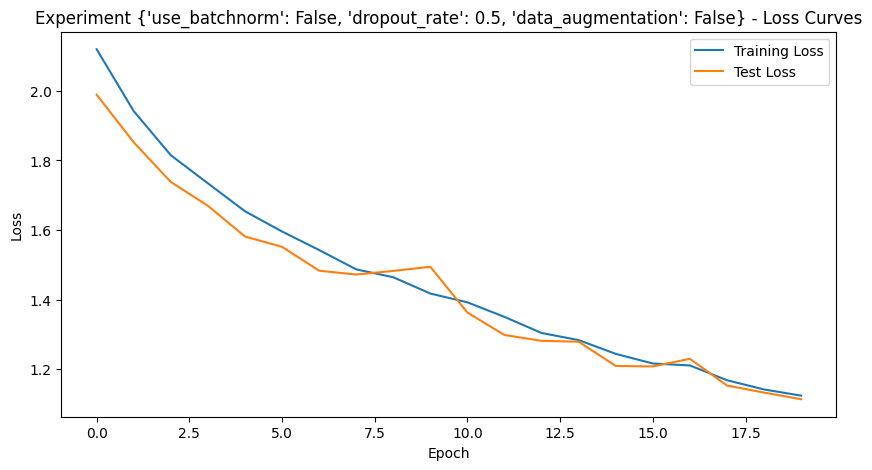

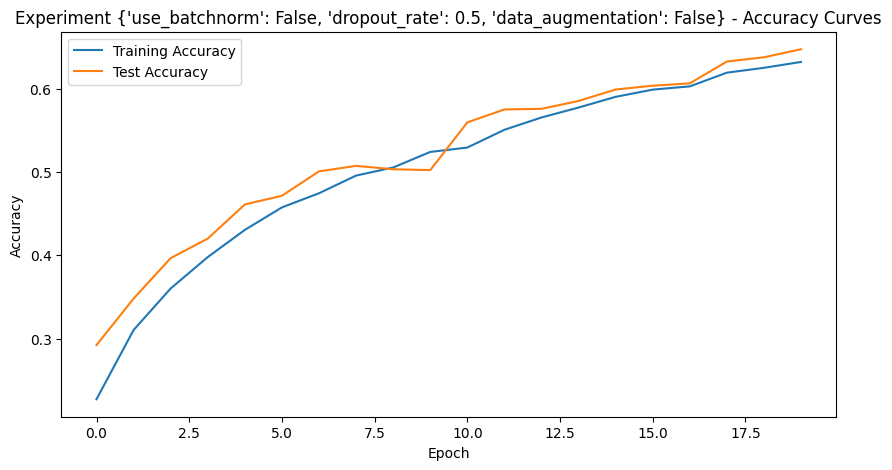

In [46]:
train_losses, test_losses, train_accuracies, test_accuracies = run_config(configs[2])
results[2] = {
    "train_losses": train_losses,
    "test_losses": test_losses,
    "train_accuracies": train_accuracies,
    "test_accuracies": test_accuracies
}

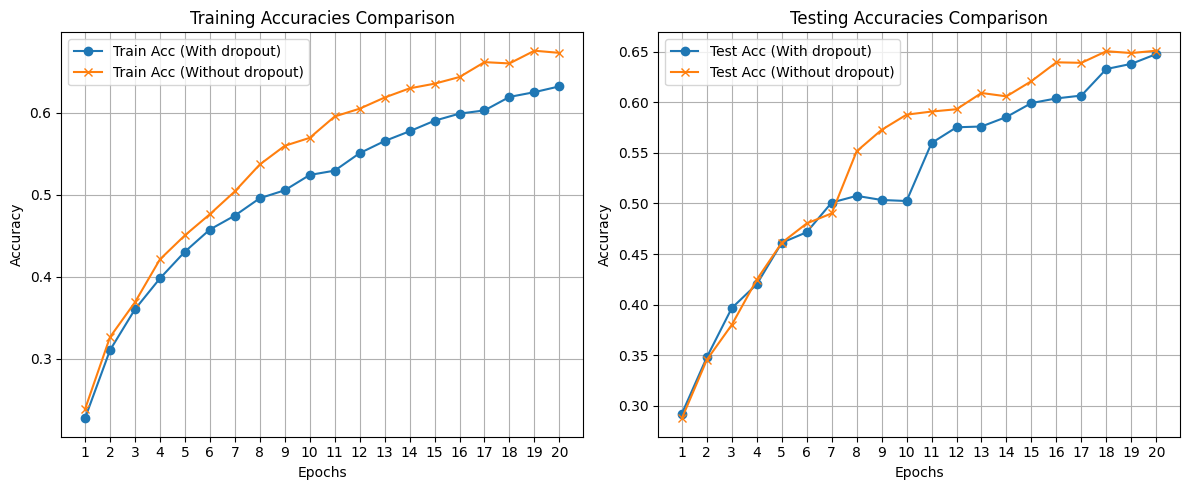

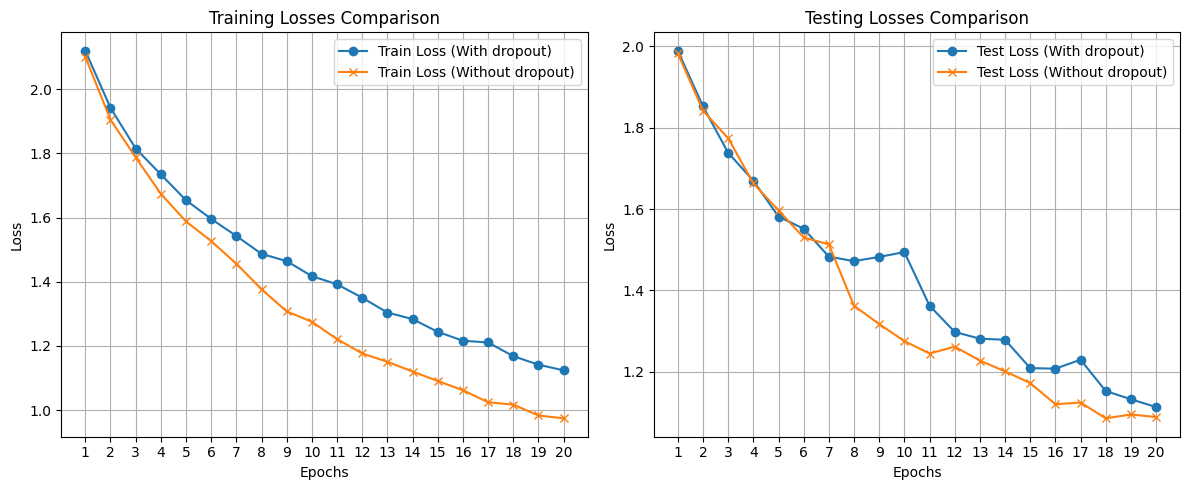

In [48]:

# Extract results for configurations with and without normalization
config_with_dropout = results[2]  
config_without_dropout = results[0]  
# Set up the epochs for x-axis
epochs = range(1, 21)  

# Plotting Train Accuracies
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)  # First subplot for accuracies
plt.plot(epochs, config_with_dropout["train_accuracies"], label='Train Acc (With dropout)', marker='o')
plt.plot(epochs, config_without_dropout["train_accuracies"], label='Train Acc (Without dropout)', marker='x')
plt.title('Training Accuracies Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(epochs)  # Set x-ticks to match epochs
plt.legend()
plt.grid()

# Plotting Test Accuracies
plt.subplot(1, 2, 2)  # Second subplot for test accuracies
plt.plot(epochs, config_with_dropout["test_accuracies"], label='Test Acc (With dropout)', marker='o')
plt.plot(epochs, config_without_dropout["test_accuracies"], label='Test Acc (Without dropout)', marker='x')
plt.title('Testing Accuracies Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(epochs)  # Set x-ticks to match epochs
plt.legend()
plt.grid()

# Show plots
plt.tight_layout()
plt.show()

# Plotting Train Losses
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)  # First subplot for losses
plt.plot(epochs, config_with_dropout["train_losses"], label='Train Loss (With dropout)', marker='o')
plt.plot(epochs, config_without_dropout["train_losses"], label='Train Loss (Without dropout)', marker='x')
plt.title('Training Losses Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs)  # Set x-ticks to match epochs
plt.legend()
plt.grid()

# Plotting Test Losses
plt.subplot(1, 2, 2)  # Second subplot for test losses
plt.plot(epochs, config_with_dropout["test_losses"], label='Test Loss (With dropout)', marker='o')
plt.plot(epochs, config_without_dropout["test_losses"], label='Test Loss (Without dropout)', marker='x')
plt.title('Testing Losses Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs)  # Set x-ticks to match epochs
plt.legend()
plt.grid()

# Show plots
plt.tight_layout()
plt.show()

# Base model with data augmentation

Epoch 1/20 => Train Loss: 2.1487, Train Acc: 0.1957, Test Loss: 2.0839, Test Acc: 0.2380
Epoch 2/20 => Train Loss: 2.0172, Train Acc: 0.2686, Test Loss: 1.9221, Test Acc: 0.3157
Epoch 3/20 => Train Loss: 1.8978, Train Acc: 0.3317, Test Loss: 1.8545, Test Acc: 0.3414
Epoch 4/20 => Train Loss: 1.8371, Train Acc: 0.3568, Test Loss: 1.7476, Test Acc: 0.3906
Epoch 5/20 => Train Loss: 1.7874, Train Acc: 0.3787, Test Loss: 1.7146, Test Acc: 0.4171
Epoch 6/20 => Train Loss: 1.7292, Train Acc: 0.4008, Test Loss: 1.6906, Test Acc: 0.4076
Epoch 7/20 => Train Loss: 1.6841, Train Acc: 0.4276, Test Loss: 1.6801, Test Acc: 0.4278
Epoch 8/20 => Train Loss: 1.6572, Train Acc: 0.4258, Test Loss: 1.5746, Test Acc: 0.4629
Epoch 9/20 => Train Loss: 1.6097, Train Acc: 0.4453, Test Loss: 1.6072, Test Acc: 0.4464
Epoch 10/20 => Train Loss: 1.5834, Train Acc: 0.4621, Test Loss: 1.5246, Test Acc: 0.4800
Epoch 11/20 => Train Loss: 1.5530, Train Acc: 0.4707, Test Loss: 1.4971, Test Acc: 0.4961
Epoch 12/20 => Trai

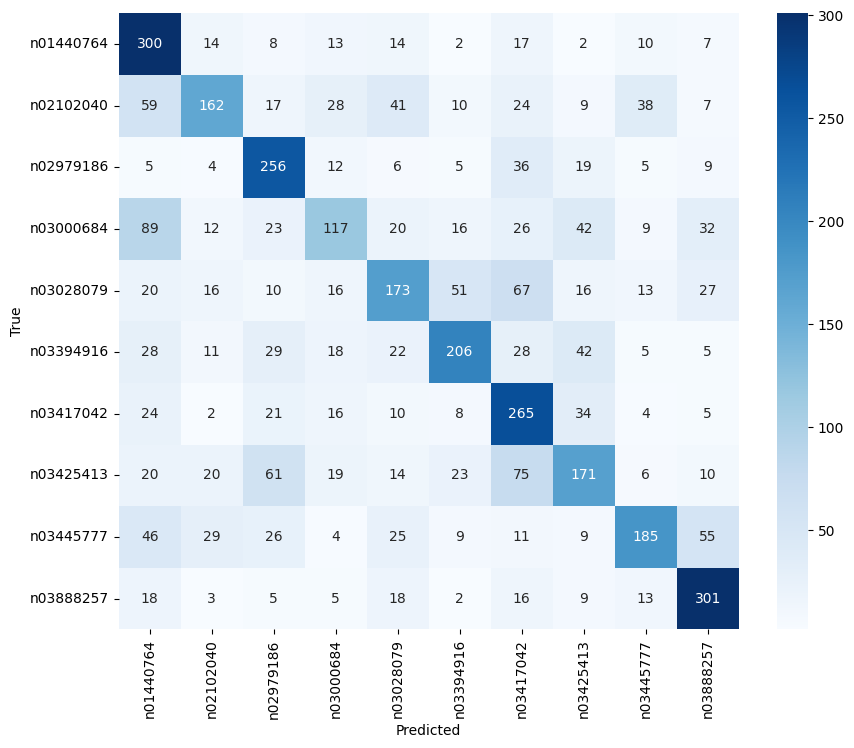

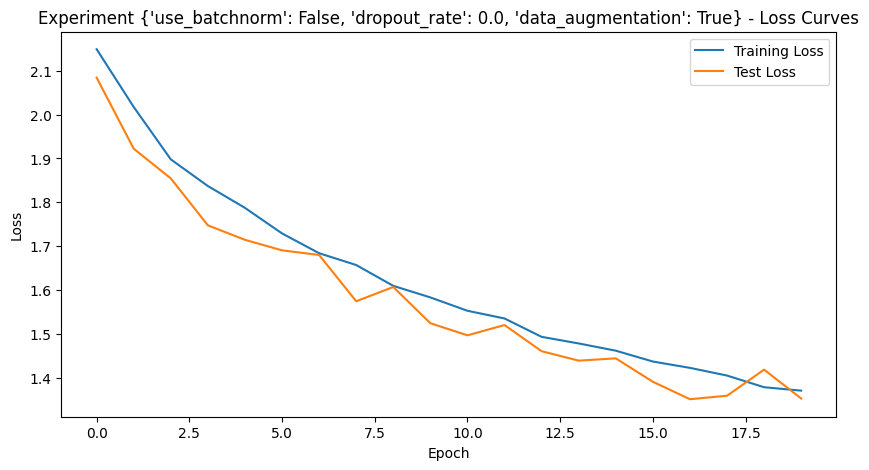

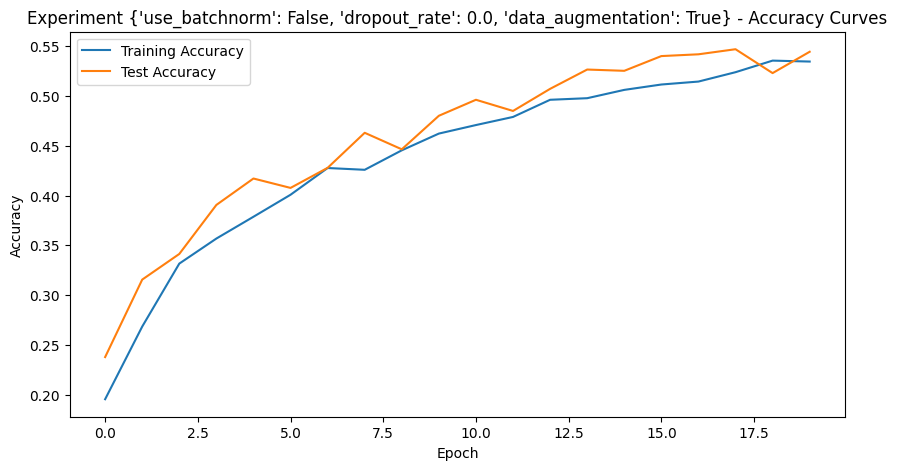

In [49]:
train_losses, test_losses, train_accuracies, test_accuracies = run_config(configs[3])
results[3] = {
    "train_losses": train_losses,
    "test_losses": test_losses,
    "train_accuracies": train_accuracies,
    "test_accuracies": test_accuracies
}

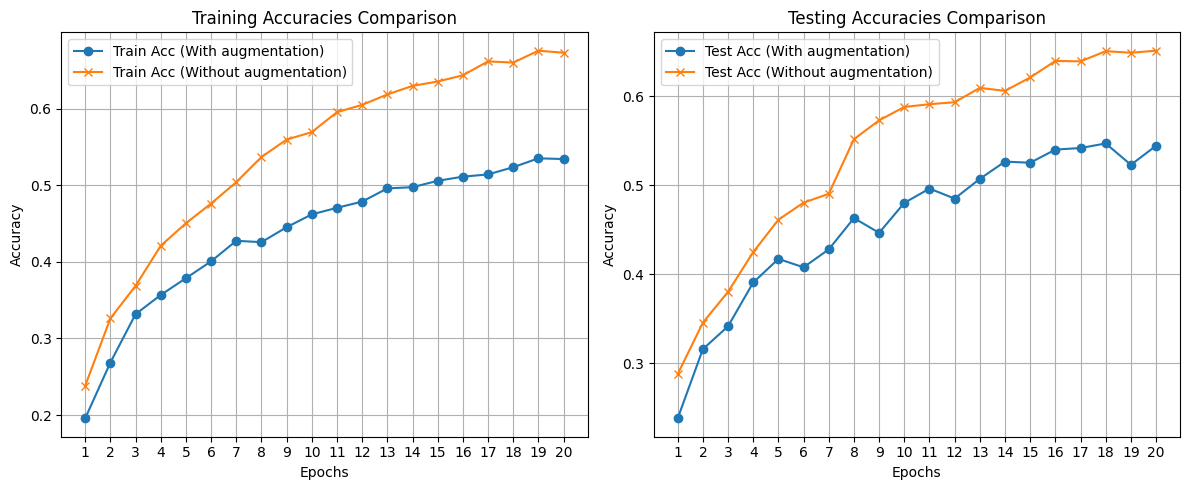

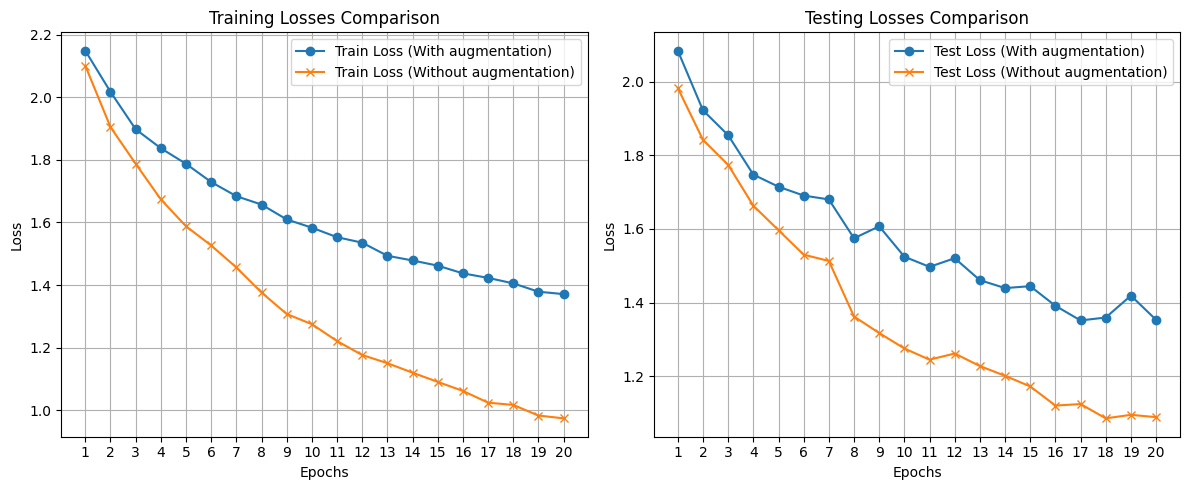

In [50]:

# Extract results for configurations with and without normalization
config_with_aug = results[3]  
config_without_aug = results[0]  
# Set up the epochs for x-axis
epochs = range(1, 21)  

# Plotting Train Accuracies
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)  # First subplot for accuracies
plt.plot(epochs, config_with_aug["train_accuracies"], label='Train Acc (With augmentation)', marker='o')
plt.plot(epochs, config_without_aug["train_accuracies"], label='Train Acc (Without augmentation)', marker='x')
plt.title('Training Accuracies Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(epochs)  # Set x-ticks to match epochs
plt.legend()
plt.grid()

# Plotting Test Accuracies
plt.subplot(1, 2, 2)  # Second subplot for test accuracies
plt.plot(epochs, config_with_aug["test_accuracies"], label='Test Acc (With augmentation)', marker='o')
plt.plot(epochs, config_without_aug["test_accuracies"], label='Test Acc (Without augmentation)', marker='x')
plt.title('Testing Accuracies Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(epochs)  # Set x-ticks to match epochs
plt.legend()
plt.grid()

# Show plots
plt.tight_layout()
plt.show()

# Plotting Train Losses
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)  # First subplot for losses
plt.plot(epochs, config_with_aug["train_losses"], label='Train Loss (With augmentation)', marker='o')
plt.plot(epochs, config_without_aug["train_losses"], label='Train Loss (Without augmentation)', marker='x')
plt.title('Training Losses Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs)  # Set x-ticks to match epochs
plt.legend()
plt.grid()

# Plotting Test Losses
plt.subplot(1, 2, 2)  # Second subplot for test losses
plt.plot(epochs, config_with_aug["test_losses"], label='Test Loss (With augmentation)', marker='o')
plt.plot(epochs, config_without_aug["test_losses"], label='Test Loss (Without augmentation)', marker='x')
plt.title('Testing Losses Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs)  # Set x-ticks to match epochs
plt.legend()
plt.grid()

# Show plots
plt.tight_layout()
plt.show()

Epoch 1/20 => Train Loss: 1.9938, Train Acc: 0.2893, Test Loss: 1.8443, Test Acc: 0.3287
Epoch 2/20 => Train Loss: 1.8017, Train Acc: 0.3741, Test Loss: 1.7498, Test Acc: 0.3796
Epoch 3/20 => Train Loss: 1.7397, Train Acc: 0.4056, Test Loss: 1.5838, Test Acc: 0.4673
Epoch 4/20 => Train Loss: 1.6771, Train Acc: 0.4299, Test Loss: 1.6201, Test Acc: 0.4199
Epoch 5/20 => Train Loss: 1.6373, Train Acc: 0.4433, Test Loss: 1.5676, Test Acc: 0.4377
Epoch 6/20 => Train Loss: 1.5772, Train Acc: 0.4665, Test Loss: 1.5235, Test Acc: 0.4848
Epoch 7/20 => Train Loss: 1.5346, Train Acc: 0.4800, Test Loss: 1.4231, Test Acc: 0.5312
Epoch 8/20 => Train Loss: 1.4996, Train Acc: 0.4921, Test Loss: 1.4236, Test Acc: 0.5279
Epoch 9/20 => Train Loss: 1.4626, Train Acc: 0.5111, Test Loss: 1.4670, Test Acc: 0.5024
Epoch 10/20 => Train Loss: 1.4338, Train Acc: 0.5230, Test Loss: 1.3563, Test Acc: 0.5478
Epoch 11/20 => Train Loss: 1.4125, Train Acc: 0.5295, Test Loss: 1.2806, Test Acc: 0.5839
Epoch 12/20 => Trai

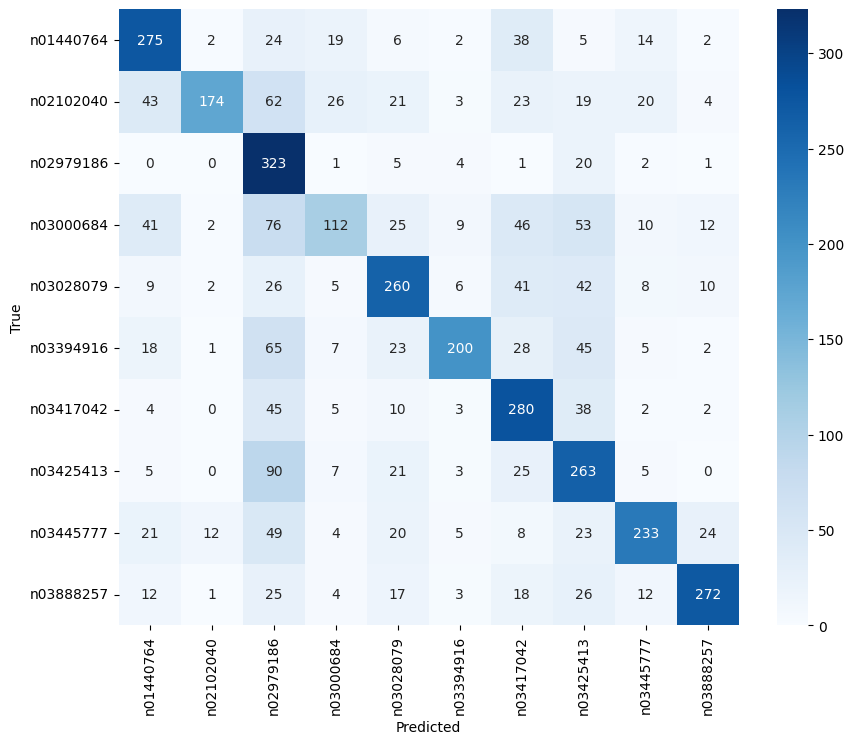

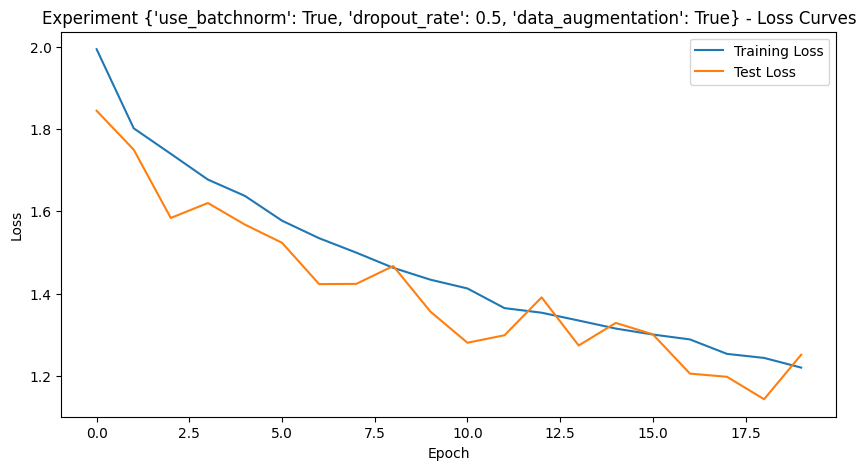

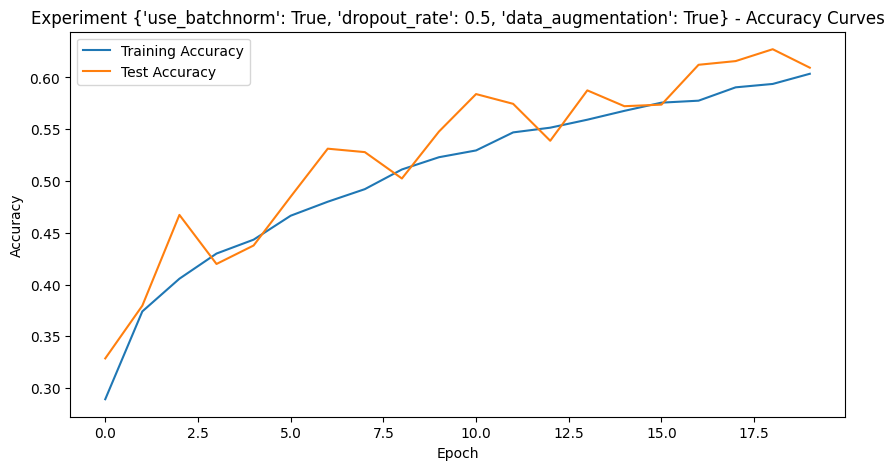

In [52]:
train_losses, test_losses, train_accuracies, test_accuracies = run_config(configs[4])
results[4] = {
    "train_losses": train_losses,
    "test_losses": test_losses,
    "train_accuracies": train_accuracies,
    "test_accuracies": test_accuracies
}

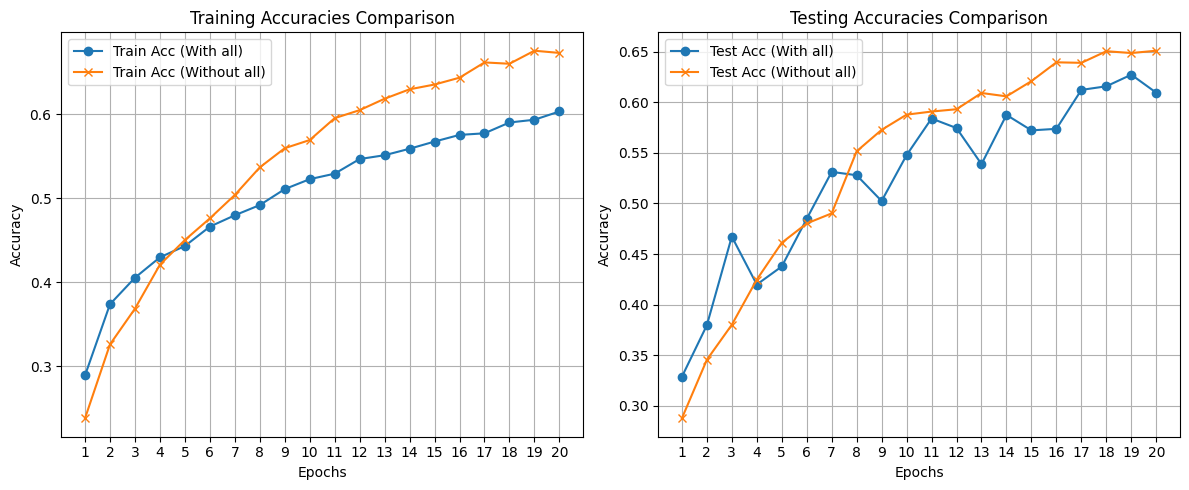

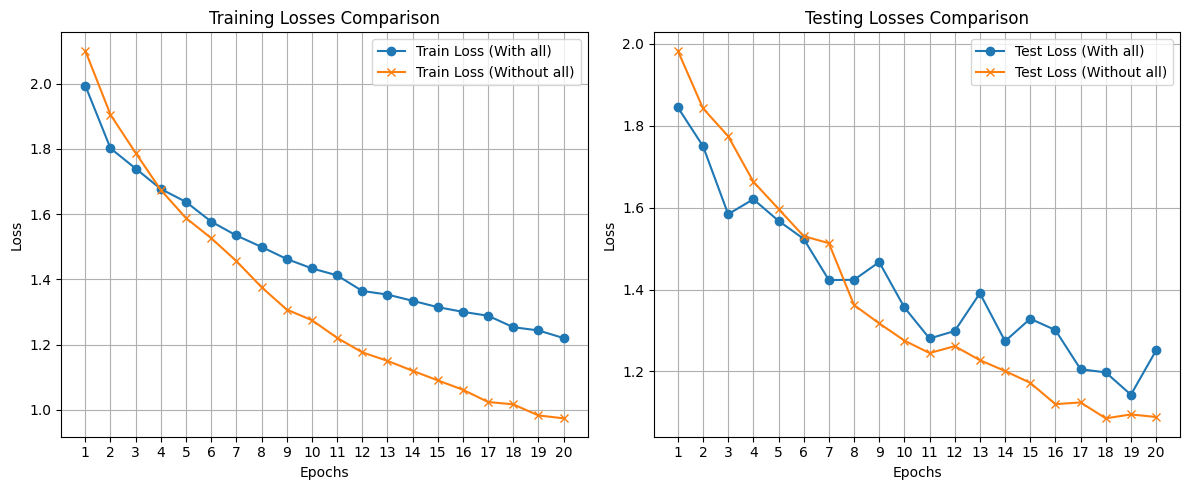

In [54]:

# Extract results for configurations with and without normalization
config_with_all = results[4]  
config_without_all = results[0]  
# Set up the epochs for x-axis
epochs = range(1, 21)  

# Plotting Train Accuracies
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)  # First subplot for accuracies
plt.plot(epochs, config_with_all["train_accuracies"], label='Train Acc (With all)', marker='o')
plt.plot(epochs, config_without_all["train_accuracies"], label='Train Acc (Without all)', marker='x')
plt.title('Training Accuracies Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(epochs)  # Set x-ticks to match epochs
plt.legend()
plt.grid()

# Plotting Test Accuracies
plt.subplot(1, 2, 2)  # Second subplot for test accuracies
plt.plot(epochs, config_with_all["test_accuracies"], label='Test Acc (With all)', marker='o')
plt.plot(epochs, config_without_all["test_accuracies"], label='Test Acc (Without all)', marker='x')
plt.title('Testing Accuracies Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(epochs)  # Set x-ticks to match epochs
plt.legend()
plt.grid()

# Show plots
plt.tight_layout()
plt.show()

# Plotting Train Losses
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)  # First subplot for losses
plt.plot(epochs, config_with_all["train_losses"], label='Train Loss (With all)', marker='o')
plt.plot(epochs, config_without_all["train_losses"], label='Train Loss (Without all)', marker='x')
plt.title('Training Losses Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs)  # Set x-ticks to match epochs
plt.legend()
plt.grid()

# Plotting Test Losses
plt.subplot(1, 2, 2)  # Second subplot for test losses
plt.plot(epochs, config_with_all["test_losses"], label='Test Loss (With all)', marker='o')
plt.plot(epochs, config_without_all["test_losses"], label='Test Loss (Without all)', marker='x')
plt.title('Testing Losses Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs)  # Set x-ticks to match epochs
plt.legend()
plt.grid()

# Show plots
plt.tight_layout()
plt.show()

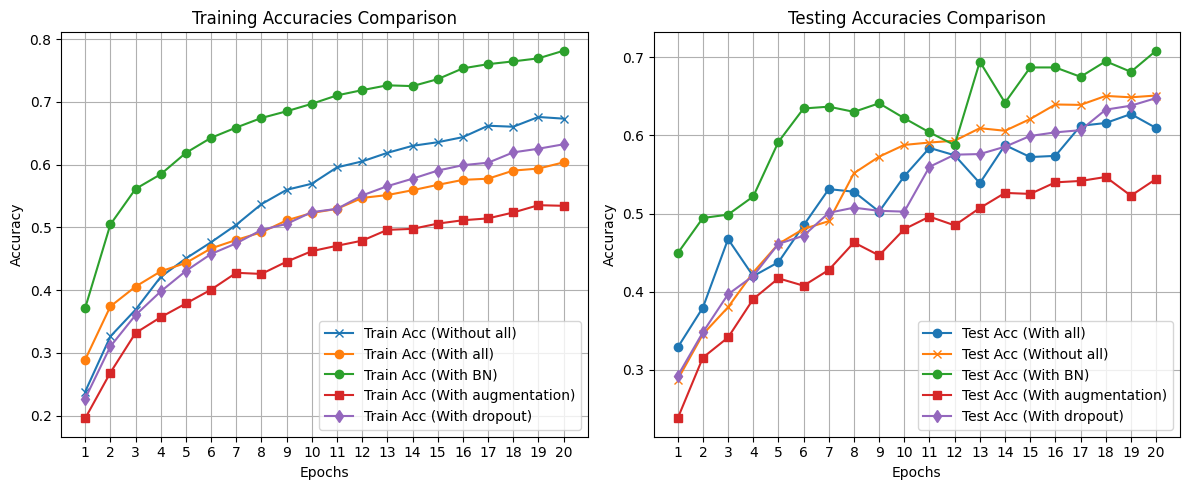

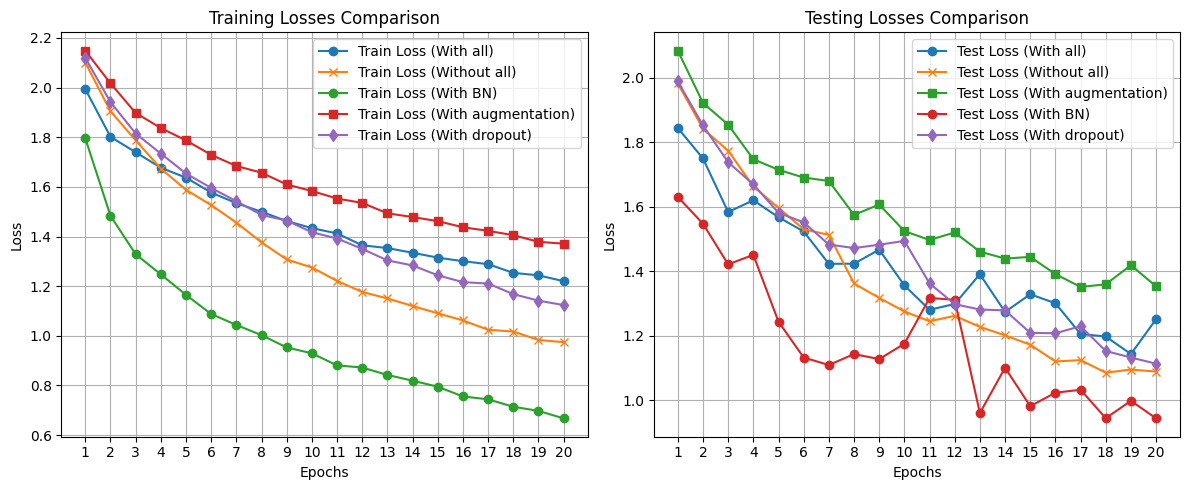

In [57]:

# Extract results for configurations with and without normalization
config_with_all = results[4]
config_with_aug = results[3]
config_with_dropout = results[2]
config_with_bn = results[1]
config_without_all = results[0]  
# Set up the epochs for x-axis
epochs = range(1, 21)  

# Plotting Train Accuracies
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)  # First subplot for accuracies
plt.plot(epochs, config_without_all["train_accuracies"], label='Train Acc (Without all)', marker='x')
plt.plot(epochs, config_with_all["train_accuracies"], label='Train Acc (With all)', marker='o')
plt.plot(epochs, config_with_bn["train_accuracies"], label='Train Acc (With BN)', marker='o')
plt.plot(epochs, config_with_aug["train_accuracies"], label='Train Acc (With augmentation)', marker='s')
plt.plot(epochs, config_with_dropout["train_accuracies"], label='Train Acc (With dropout)', marker='d')
plt.title('Training Accuracies Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(epochs)  # Set x-ticks to match epochs
plt.legend()
plt.grid()

# Plotting Test Accuracies
plt.subplot(1, 2, 2)  # Second subplot for test accuracies
plt.plot(epochs, config_with_all["test_accuracies"], label='Test Acc (With all)', marker='o')
plt.plot(epochs, config_without_all["test_accuracies"], label='Test Acc (Without all)', marker='x')
plt.plot(epochs, config_with_bn["test_accuracies"], label='Test Acc (With BN)', marker='o')
plt.plot(epochs, config_with_aug["test_accuracies"], label='Test Acc (With augmentation)', marker='s')
plt.plot(epochs, config_with_dropout["test_accuracies"], label='Test Acc (With dropout)', marker='d')
plt.title('Testing Accuracies Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(epochs)  # Set x-ticks to match epochs
plt.legend()
plt.grid()

# Show plots
plt.tight_layout()
plt.show()

# Plotting Train Losses
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)  # First subplot for losses
plt.plot(epochs, config_with_all["train_losses"], label='Train Loss (With all)', marker='o')
plt.plot(epochs, config_without_all["train_losses"], label='Train Loss (Without all)', marker='x')
plt.plot(epochs, config_with_bn["train_losses"], label='Train Loss (With BN)', marker='o')
plt.plot(epochs, config_with_aug["train_losses"], label='Train Loss (With augmentation)', marker='s')
plt.plot(epochs, config_with_dropout["train_losses"], label='Train Loss (With dropout)', marker='d')
plt.title('Training Losses Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs)  # Set x-ticks to match epochs
plt.legend()
plt.grid()

# Plotting Test Losses
plt.subplot(1, 2, 2)  # Second subplot for test losses
plt.plot(epochs, config_with_all["test_losses"], label='Test Loss (With all)', marker='o')
plt.plot(epochs, config_without_all["test_losses"], label='Test Loss (Without all)', marker='x')
plt.plot(epochs, config_with_aug["test_losses"], label='Test Loss (With augmentation)', marker='s')
plt.plot(epochs, config_with_bn["test_losses"], label='Test Loss (With BN)', marker='o')
plt.plot(epochs, config_with_dropout["test_losses"], label='Test Loss (With dropout)', marker='d')
plt.title('Testing Losses Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs)  # Set x-ticks to match epochs
plt.legend()
plt.grid()

# Show plots
plt.tight_layout()
plt.show()